## Apple Tweet - Sentiment Analysis using NLP


In this project, we plan to look into the sentiment around the Apple computers on tweets, containing #AAPL, @apple, etc.

Tweets can be positive, neutral or negative.

The task is to identify whether the tweet about Apple is positive, neutral or negative. If the tweet isn't about Apple, identification should be neutral.

Sentiment are represented as follows:
* Positive - 5
* Neutral - 3
* Negative - 1

#### Import Libraries

In [174]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import string
import nltk
# if you have never done so, you need to download stopwords from nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
import re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB


from nltk.sentiment.util import mark_negation
from nltk import word_tokenize


#format columns so comments don't get cut off
pd.set_option('display.max_columns', None) 

#### Read input data

In [175]:
df = pd.read_csv("Apple-Twitter-Sentiment-DFE.csv", encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [176]:
#Size of dataset
df.shape

(3886, 12)

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [178]:
#Consider only the sentiment and text column for our analysis
#apple_tweet = df[['sentiment','text']].copy()
apple_tweet = df.copy()
apple_tweet.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [179]:
# Adding an extra column to calculate review length
apple_tweet['Text_length'] = apple_tweet['text'].apply(len)
apple_tweet.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text,Text_length
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...,65
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,94
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...,51
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...,136
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL,44


In [180]:
apple_tweet['sentiment'].value_counts()

3               2162
1               1219
5                423
not_relevant      82
Name: sentiment, dtype: int64

In [181]:
#Drop rows that contain "not relevant" in Sentiment column
apple_tweet = apple_tweet[apple_tweet.sentiment != 'not_relevant']

In [182]:
apple_tweet['sentiment'].value_counts()

3    2162
1    1219
5     423
Name: sentiment, dtype: int64

There are equal number of positive and negative tweets and there are no neutral tweets.

In [183]:
#Check for null values
apple_tweet.isnull().sum()

_unit_id                   0
_golden                    0
_unit_state                0
_trusted_judgments         0
_last_judgment_at        102
sentiment                  0
sentiment:confidence       0
date                       0
id                         0
query                      0
sentiment_gold          3702
text                       0
Text_length                0
dtype: int64

#### Generating a Word Cloud of Reviews

Let's look at a Wordcloud of our data to see what words are most frequently showing up!

In [184]:
#!pip install wordcloud
from wordcloud import WordCloud

(-0.5, 1599.5, 1199.5, -0.5)

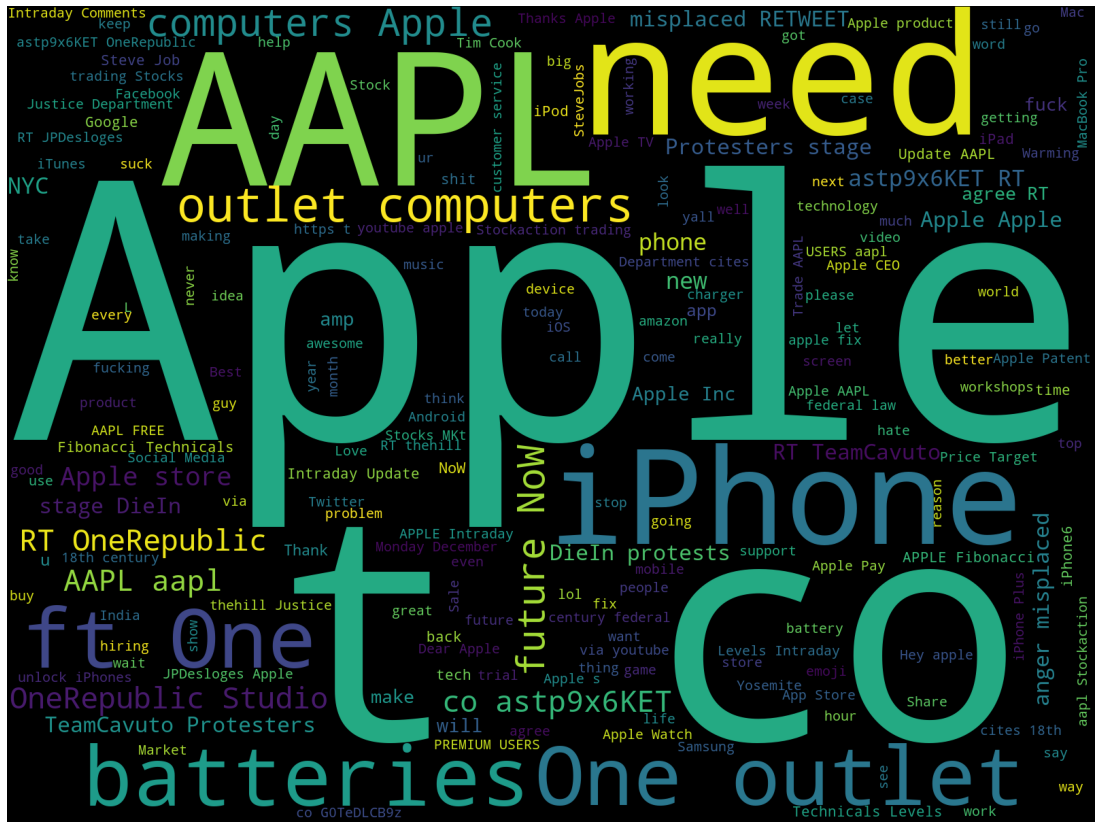

In [185]:
cloud = WordCloud(width=1600, height=1200).generate(" ".join(apple_tweet['text'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

#### Text Preprocessing

In [186]:
# Lemmatize words, and remove stop words and punctuation
lemmatizer = WordNetLemmatizer()

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove URLs
    2. Remove punctuation
    3. Remove numbers
    4. Remove stopwords
    5. Return the cleaned text as a list of lemmatized words
    '''
    
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text, flags=re.MULTILINE)
    
    text = ''.join([t for t in text if t not in string.punctuation])
    
    text = ''.join([t for t in text if not t.isdigit()])
    
    return [lemmatizer.lemmatize(word) for word in text.split() if word.lower() not in stopwords.words('english')]

In [196]:
# Split data into training and test sets
#y = pd.get_dummies(apple_tweet['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(apple_tweet,
                                                    apple_tweet['sentiment'],
                                                    test_size=0.2)
                                                    

In [197]:
y_test

2520    3
2173    3
449     5
290     5
1625    3
       ..
1580    3
3187    3
1671    5
407     5
332     1
Name: sentiment, Length: 761, dtype: object

### Apply TF-IDF Vectorizer

Creates a document-term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.

In [198]:
# Fit a basic TFIDF Vectorizer and view the results
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=text_process)
#X_tfidf = tfidf_vect.fit_transform(apple_tweet['text'])

train_features = tfidf_vect.fit_transform(X_train['text'])
test_features =  tfidf_vect.transform(X_test['text'])


In [199]:
print('Length of Vectorizer Vocabulary: ', len(tfidf_vect.vocabulary_))
print(train_features.shape)
print(tfidf_vect.get_feature_names()[0:20])

Length of Vectorizer Vocabulary:  6701
(3043, 6701)
['AA', 'AAPL', 'AAPLA', 'AAPLAfter', 'AAPLAfterhours', 'AAPLAlabama', 'AAPLAndroid', 'AAPLApple', 'AAPLApples', 'AAPLBloomberg', 'AAPLCanaccord', 'AAPLCorrupt', 'AAPLDid', 'AAPLDont', 'AAPLE', 'AAPLFast', 'AAPLFinally', 'AAPLGoogle', 'AAPLHas', 'AAPLHeres']


C:\Users\laksh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Random Forest Model

In [200]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(train_features,y_train)

In [201]:
y_pred = rf_model.predict(test_features)

In [202]:
#importing the required libraries to measure accuracy
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion_matrix")
print(confusion_matrix(y_test,y_pred))

Confusion_matrix
[[167  90   1]
 [ 32 380   4]
 [ 15  53  19]]


In [203]:
target_names = ['Negative','Neutral','Positive']
print("Classification Matrix")
print(classification_report(y_test,y_pred, target_names = target_names))

Classification Matrix
              precision    recall  f1-score   support

    Negative       0.78      0.65      0.71       258
     Neutral       0.73      0.91      0.81       416
    Positive       0.79      0.22      0.34        87

    accuracy                           0.74       761
   macro avg       0.77      0.59      0.62       761
weighted avg       0.75      0.74      0.72       761



### Naive Bayes Model

In [204]:
nb = MultinomialNB()
nb_model = nb.fit(train_features,y_train)

In [205]:
y_pred = nb_model.predict(test_features)

In [206]:
print("Confusion_matrix")
print(confusion_matrix(y_test,y_pred))

Confusion_matrix
[[183  75   0]
 [ 39 377   0]
 [ 19  60   8]]


In [207]:
target_names = ['Negative','Neutral','Positive']
print("Classification Matrix")
print(classification_report(y_test,y_pred, target_names = target_names))

Classification Matrix
              precision    recall  f1-score   support

    Negative       0.76      0.71      0.73       258
     Neutral       0.74      0.91      0.81       416
    Positive       1.00      0.09      0.17        87

    accuracy                           0.75       761
   macro avg       0.83      0.57      0.57       761
weighted avg       0.77      0.75      0.71       761



#### Accuracy of Random Forest is 74% 
#### Accuracy of Naive Bayes is 75 %